# Linear Models for Sequential Trajectory Prediction

This notebook demonstrates my first steps in exploring the trajectory prediction problem with neural networks. Here, I explore how to predict the position of a **free-falling** single ball on the next frame of the simulation using concatenated positions of the same ball in the previous three frames.

- Three frames are used to make assure that this prediction is possible analytically. Using numerical differentiation, velocity of the object can be approximated as difference of positions over the time interval, and acceleration - as difference in velocities over the time interval, there the interval equals to 1 simulation step. Thus, triplet of coordinates would be enough to predict the following coordinates analytically, and I expect simple linear models to be able to learn this prediction.

Using Phyre, I generated a dataset of a single ball in free-fall. Essentially, I am only focused on the time when ball is in the free-fall. However, I did not remove the part of the simulation when the ball collides with the floor to see how the simplest models will be able to deal with this situation, with a hope that it will inspire my next steps.

I used three different modification of simple linear models to make such predictions. I then mapped the predicted results into a plot to see the predictions for the entire scenario. It is important to not be confused by these plots - the models do not predict the entire trajectory, but rather only a single frame at a time.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import sys

if '..' not in sys.path:
    sys.path.append('..')
    
from data import OneBallFreeFallThreeFramesDataset

from models.LinearModelsForSequential1DFreeFall import SequentialDense1DFreeFallModel, SequentialLinearWithCtgVelocity1DFreeFallModel, SequentialKinem1DFreeFallModel

Let's start with importing the dataset.

In [5]:
train_data, test_data = OneBallFreeFallThreeFramesDataset.train_test_split('../../data/raw/single-ball-free-fall', test_frac=0.3)

train_test_split response: test fraction rounded to 0.2999440402909905 (1608 simulations)


In this scenario, the length of each simulation is different. To avoid dimensional mismatch, we have to use the batch size of 1.

In [6]:
batch_size = 1

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Simple dense network with ReLU activations

The first model that I tried is a simple three-layer linear network is ReLU activations. The hidden layer only has two neurons that are supposed to symbolize velocity and acceleration. The schematic representation of this model is shown below.

<img src="../visuals/1D_sequential_free-fall_dense.png" width=800>

The reason why the ReLU activation is added to the output layer is in the form of data that we are dealing with - the simulator provides coordinates of the object relative to the size of the scene, so they are always bound between 0 and 1. The last ReLU activation assures that the network does not make negative predictions.

In [8]:
model1 = SequentialDense1DFreeFallModel()
print(model1)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model1(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0

SequentialDense1DFreeFallModel(
  (hidden): Linear(in_features=3, out_features=2, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)
Epoch 0 complete. Training loss: 7.734259778672367
Epoch 1 complete. Training loss: 2.6472076881674695
Epoch 2 complete. Training loss: 2.109143921134228
Epoch 3 complete. Training loss: 2.0168712523207173
Epoch 4 complete. Training loss: 1.9485717074061117
Epoch 5 complete. Training loss: 1.8818963667854725
Epoch 6 complete. Training loss: 1.8165885435984883
Epoch 7 complete. Training loss: 1.7526108346886557
Epoch 8 complete. Training loss: 1.6920058160885514
Epoch 9 complete. Training loss: 1.6362452185003646
Epoch 10 complete. Training loss: 1.5863115686469451
Epoch 11 complete. Training loss: 1.5419166460685343
Epoch 12 complete. Training loss: 1.5036053172743138
Epoch 13 complete. Training loss: 1.4714478691244857
Epoch 14 complete. Training loss: 1.4446199095344419
Epoch 15 complete. Training loss: 1.4229659874164824
Epoch 16

The plot below show the training loss per epoch.

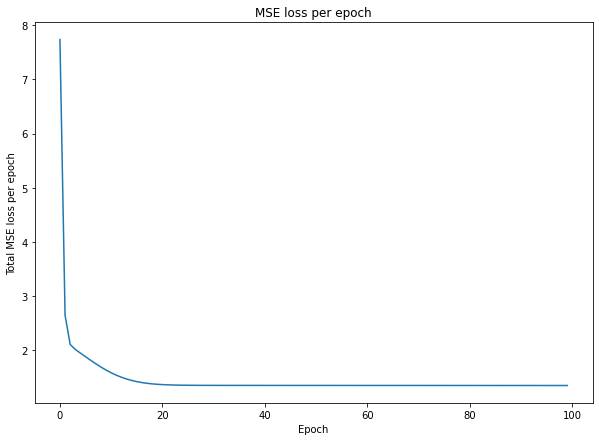

In [15]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch)
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.show()

Finally, let's take a look at the first 10 predicted "trajectories" - predictions that correspond to a single scenario.

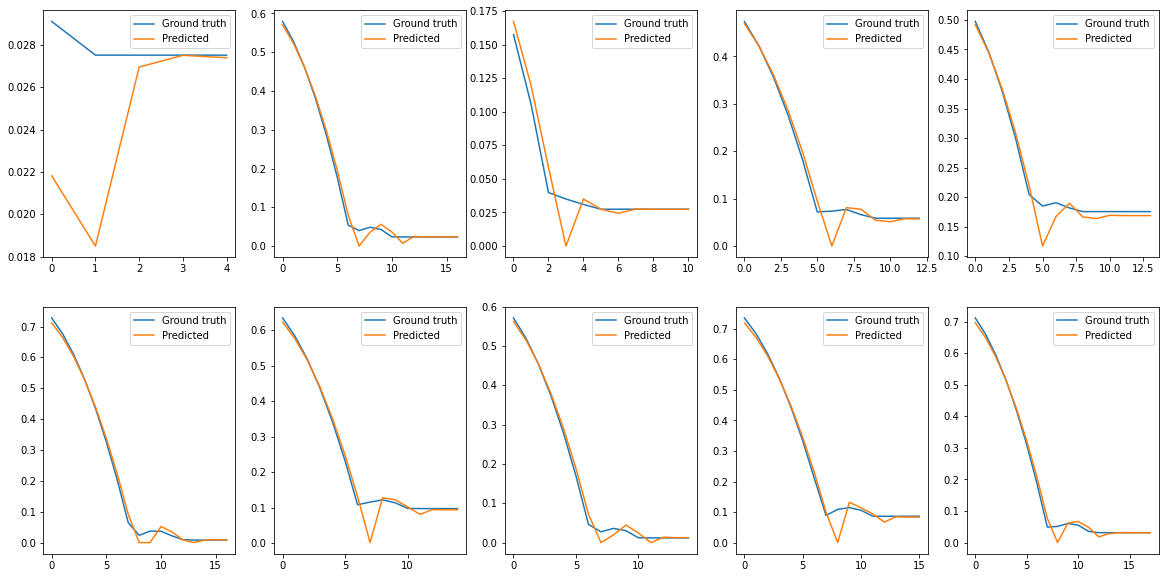

In [16]:
count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model1(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

# Linear network with ReLU and Cotan activations in the hidden layer

**TODO: Ask Watson about it and make a write up**

<img src="../visuals/1D_sequential_free-fall_dense_ctg.png" width=800>

In [17]:
model2 = SequentialLinearWithCtgVelocity1DFreeFallModel()
print(model2)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model2(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0

SequentialLinearWithCtgVelocity1DFreeFallModel(
  (velocity): Linear(in_features=3, out_features=1, bias=True)
  (acceleration): Linear(in_features=3, out_features=1, bias=True)
  (output): Linear(in_features=2, out_features=1, bias=True)
)
Epoch 0 complete. Training loss: 7.37895839633677
Epoch 1 complete. Training loss: 1.8187580088968005
Epoch 2 complete. Training loss: 1.6377765697564257
Epoch 3 complete. Training loss: 1.5360596050469724
Epoch 4 complete. Training loss: 1.4717809726613957
Epoch 5 complete. Training loss: 1.4317575053672105
Epoch 6 complete. Training loss: 1.4075114722934812
Epoch 7 complete. Training loss: 1.393152239459921
Epoch 8 complete. Training loss: 1.3843900040001387
Epoch 9 complete. Training loss: 1.3789155533499144
Epoch 10 complete. Training loss: 1.3751813022020656
Epoch 11 complete. Training loss: 1.3726243491422316
Epoch 12 complete. Training loss: 1.3707642463850647
Epoch 13 complete. Training loss: 1.3692377966387639
Epoch 14 complete. Training lo

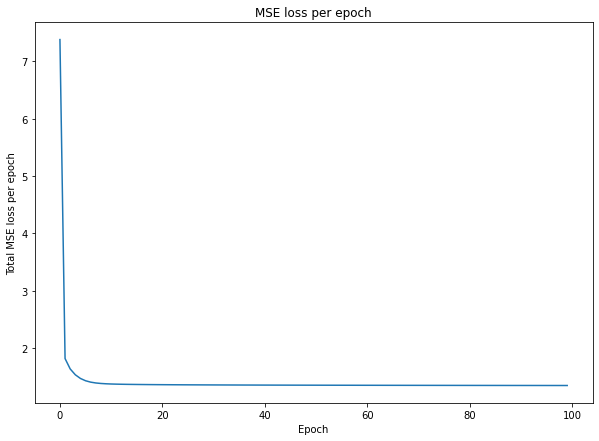

In [18]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch)
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.show()

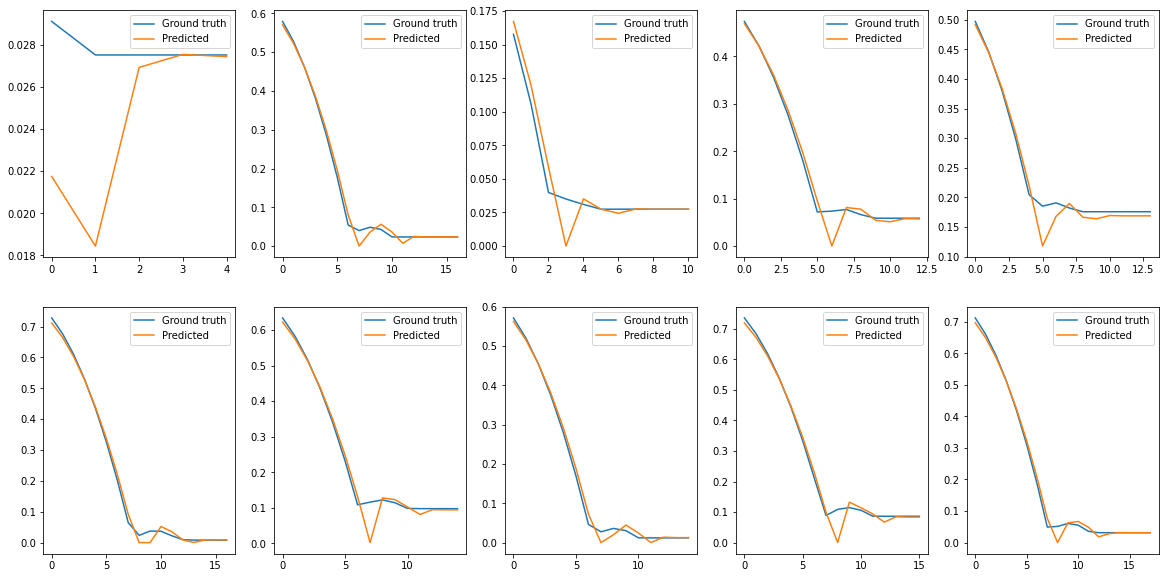

In [19]:
count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model2(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

# Linear network with direct connection of one of the inputs to the output

This network architecture is inspired by the kinematic formulas. According to them,

$$y = y_0 - v_0 t - \frac{gt^2}{2}$$

I thought that if my hidden neurons are meant to represent velocity and acceleration, then mocking this formula by adding a direct connection from one of the inputs to the output can lead to better results. The schematic representation of this network is given below.

<img src="../visuals/1D_sequential_free-fall_dense_direct_connection.png" width=800>

In [20]:
model3 = SequentialKinem1DFreeFallModel()
print(model3)

learning_rate = 0.1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=learning_rate)


# Training the model on 100 epochs
num_epochs = 100

# This array will store the loss values per epoch
loss_per_epoch = []

# This variable is needed to calculate the total epoch loss
epoch_loss = 0

# Training
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # For each data instance we need to reset the optimizer gradients
        optimizer.zero_grad()
        
        pred = model3(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        
    loss_per_epoch.append(epoch_loss)
    
    # Keeping training log
    print(f'Epoch {epoch} complete. Training loss: {epoch_loss}')
    
    epoch_loss = 0

SequentialKinem1DFreeFallModel(
  (hidden): Linear(in_features=3, out_features=2, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
)
Epoch 0 complete. Training loss: 7.60271793965785
Epoch 1 complete. Training loss: 2.1985621353192983
Epoch 2 complete. Training loss: 1.6442506404708075
Epoch 3 complete. Training loss: 1.56064191781332
Epoch 4 complete. Training loss: 1.5317136888607863
Epoch 5 complete. Training loss: 1.5080797659736453
Epoch 6 complete. Training loss: 1.4864801111145614
Epoch 7 complete. Training loss: 1.466484621506335
Epoch 8 complete. Training loss: 1.448167702968421
Epoch 9 complete. Training loss: 1.4316966405251037
Epoch 10 complete. Training loss: 1.4172408041169051
Epoch 11 complete. Training loss: 1.404568700261965
Epoch 12 complete. Training loss: 1.393615598723597
Epoch 13 complete. Training loss: 1.3843074440518701
Epoch 14 complete. Training loss: 1.3765065785433146
Epoch 15 complete. Training loss: 1.3701363100816337
Epoch 16 compl

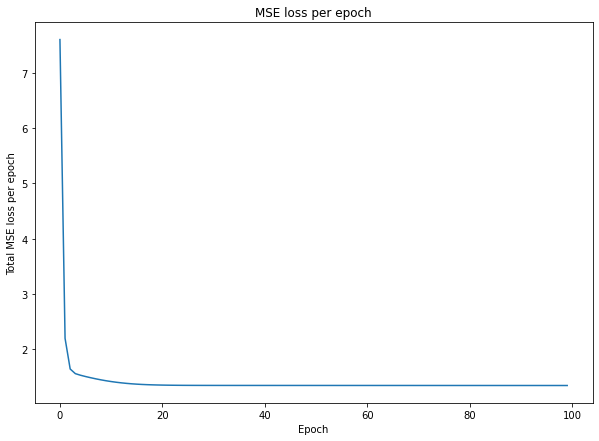

In [21]:
plt.figure(figsize=(10,7))
plt.plot(loss_per_epoch)
plt.title('MSE loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Total MSE loss per epoch')
plt.show()

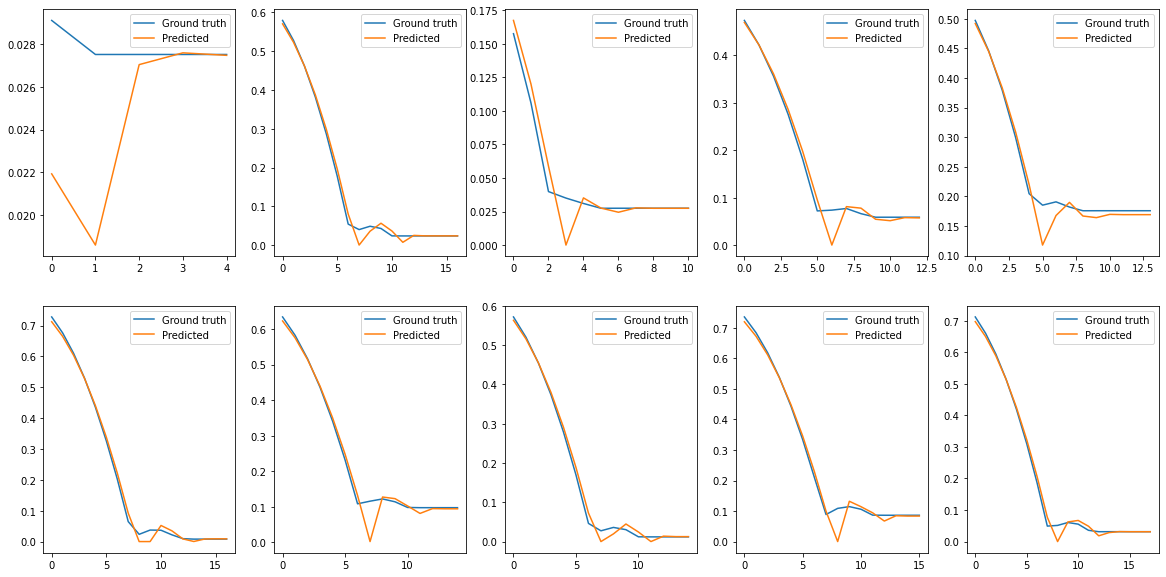

In [22]:
count = 0
with torch.no_grad():
    fig, axs = plt.subplots(2, 5, figsize=(20,10))
    for X, y in test_dataloader:
        if count == 10: 
            break
        pred = model3(X)
        axs[int(count >= 5)][count % 5].plot(y.reshape(1,-1)[0], label='Ground truth')
        axs[int(count >= 5)][count % 5].plot(pred.reshape(1,-1)[0], label='Predicted')
        axs[int(count >= 5)][count % 5].legend()
        count += 1

## Conclusion

**TODO: write it up**